### 1. Perceptron Classifier Construction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings("ignore")
np.set_printoptions(precision=2, suppress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/MEng AI/AI 201/Programming Assignment IV/Data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/MEng AI/AI 201/Programming Assignment IV/Data


In [ ]:
# Function to generate synthetic data for binary classification
def generate_data():
    """
    Generates 100 samples for each class from two different normal distributions.
    Returns shuffled data and labels ready for training and testing.
    """
    # Generate 100 samples from a multivariate normal distribution centered at [0, 0] for class 1
    class_1 = np.random.multivariate_normal([0, 0], np.eye(2), 100)
    # Generate 100 samples from a multivariate normal distribution centered at [10, 10] for class 2
    class_2 = np.random.multivariate_normal([10, 10], np.eye(2), 100)

    # Assign labels for the classes, -1 for class 1 and 1 for class 2
    labels_1 = -np.ones(100)  # Labels for class 1
    labels_2 = np.ones(100)   # Labels for class 2

    # Combine first 50 of each class for training data
    train_data = np.vstack((class_1[:50], class_2[:50]))
    train_labels = np.hstack((labels_1[:50], labels_2[:50]))
    # Combine last 50 of each class for test data
    test_data = np.vstack((class_1[50:], class_2[50:]))
    test_labels = np.hstack((labels_1[50:], labels_2[50:]))

    # Shuffle the training dataset to mix class 1 and class 2 samples
    train_indices = np.random.permutation(len(train_labels))  # Generate a random permutation of indices
    train_data = train_data[train_indices]  # Apply the permutation to the training data
    train_labels = train_labels[train_indices]  # Apply the permutation to the training labels

    return train_data, train_labels, test_data, test_labels  # Return the prepared datasets and labels

In [ ]:
# Function to implement the Pocket Algorithm for perceptron learning
def classify(features, labels, max_iterations=10000):
    """
    Trains a perceptron using the Pocket Algorithm with the given number of iterations.
    Returns the best weights found during training.
    """
    weights = np.zeros(features.shape[1] + 1)  # Initialize weights (including bias term) to zeros
    pocket_weights = np.copy(weights)  # Initialize the best weights found as a copy of the initial weights
    pocket_misclassifications = len(labels)  # Initialize the number of misclassifications with the maximum possible

    features = np.hstack((np.ones((features.shape[0], 1)), features))  # Add a column of ones to features for the bias term

    for _ in range(max_iterations):  # Iterate up to max_iterations times
        random_idx = np.random.randint(len(labels))  # Randomly pick an index of a sample
        xi = features[random_idx]  # Extract the feature vector of the chosen sample
        yi = labels[random_idx]  # Extract the label of the chosen sample
        if np.sign(xi @ weights) != yi:  # Check if the current prediction is wrong
            weights += yi * xi  # Update the weights
            misclassifications = np.sum(np.sign(features @ weights) != labels)  # Count the number of misclassifications
            if misclassifications < pocket_misclassifications:  # Check if the new weights perform better
                pocket_misclassifications = misclassifications  # Update the best number of misclassifications
                pocket_weights = np.copy(weights)  # Update the best weights

    return pocket_weights  # Return the best weights found during training

In [ ]:
# Function to predict with a perceptron and measure the sum of squared errors
def predict(features, labels, weights):
    """
    Uses the perceptron model to make predictions and calculate the sum of squared errors.
    """
    features = np.hstack((np.ones((features.shape[0], 1)), features))  # Add bias term to feature matrix
    predictions = np.sign(features @ weights)  # Compute predictions using sign of weighted sum
    errors = labels - predictions  # Calculate the difference between actual and predicted labels
    sum_of_squares = np.sum(errors**2)  # Compute the sum of squared differences
    return sum_of_squares  # Return the sum of squared errors

In [ ]:
# Main function to execute the task
def main():
    train_data, train_labels, test_data, test_labels = generate_data()  # Generate or load data sets
    weights = classify(train_data, train_labels)  # Train the perceptron and retrieve the best weights
    sum_of_squares = predict(test_data, test_labels, weights)  # Predict and calculate sum of squared errors on test set
    print(f'Sum of Squared Errors on the Test Set: {sum_of_squares}')  # Output the sum of squared errors

In [ ]:
# Execute the main function
if __name__ == "__main__":
    main()  # Entry point of the script, calling main function when script is executed

Sum of Squared Errors on the Test Set: 12.0


### 2. Adaboost Construction and Evaluation

In [ ]:
def adabtrain(features, labels, n_learners=10):
    n_samples = features.shape[0]  # Number of samples in the dataset
    instance_weights = np.ones(n_samples) / n_samples  # Initialize uniform weights for each instance
    classifiers = []  # To store weak learners (perceptrons)
    alphas = []  # To store weights for each classifier in the ensemble

    for t in range(n_learners):
        # Sample a new training set St from S with replacement according to the instance weights
        sample_indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=instance_weights)
        St_features = features[sample_indices]  # Extract sampled features
        St_labels = labels[sample_indices]  # Extract sampled labels

        # Train a weak learner on St to obtain a hypothesis ht
        classifier_weights = classify(St_features, St_labels, max_iterations=100)

        # Compute training error et of ht on the full dataset S
        predictions = np.sign(np.dot(np.hstack((np.ones((n_samples, 1)), features)), classifier_weights))
        et = np.sum(instance_weights * (predictions != labels)) / np.sum(instance_weights)  # Weighted error rate

        # Avoid division by zero or log(0) by setting a lower bound on et
        et = max(et, 1e-10)

        # Skip the current learner if its error rate is greater than 0.5
        if et > 0.5:
            continue  # This skips the following steps for the current learner

        # Add the classifier to the ensemble since its error is <= 0.5
        classifiers.append(classifier_weights)

        # Compute the classifier's weight, alpha_t, using its error rate et
        alpha_t = 0.5 * np.log((1 - et) / et)
        alphas.append(alpha_t)  # Store the weight of the classifier

        # Update instance weights w_t for the next iteration
        instance_weights *= np.exp(-alpha_t * labels * predictions)  # Adjust weights based on correctness
        Zt = np.sum(instance_weights)  # Normalization factor to ensure that weights sum to 1
        instance_weights /= Zt  # Normalize the weights to form a probability distribution

    return classifiers, alphas  # Return the list of classifiers and their corresponding weights

In [ ]:
# Function to predict with the Adaboost ensemble
def adabpredict(features, classifiers, alphas):
    n_samples = features.shape[0]  # Determine the number of samples in the dataset
    final_prediction = np.zeros(n_samples)  # Initialize array for sum of weighted predictions

    # Sum the weighted predictions from all classifiers
    for classifier, alpha in zip(classifiers, alphas):
        prediction = np.sign(np.dot(np.hstack((np.ones((n_samples, 1)), features)), classifier))  # Calculate prediction of each classifier
        final_prediction += alpha * prediction  # Weight prediction by classifier's alpha and accumulate

    return np.sign(final_prediction)  # Return final prediction by taking the sign of the accumulated predictions

In [ ]:
# Function to load and prepare the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path, header=None)  # Load data from CSV file into a DataFrame
    features = df.iloc[:, 1:].values  # Extract features from all rows and all columns except the first
    labels = df.iloc[:, 0].values  # Extract the first column as labels
    labels[labels == 0] = -1  # Convert labels from 0 to -1 to fit the Adaboost label requirements
    return features, labels  # Return the processed features and labels

In [ ]:
# Main execution function
def main():
    # Load and process the banana dataset
    banana_features, banana_labels = load_dataset('banana_data.csv')  # Load banana dataset from CSV
    # Split the banana dataset into training and testing parts
    banana_train_features, banana_train_labels = banana_features[:400], banana_labels[:400]  # First 400 for training
    banana_test_features, banana_test_labels = banana_features[400:], banana_labels[400:]  # Remaining for testing

    # Load and process the splice dataset
    splice_features, splice_labels = load_dataset('splice_data.csv')  # Load splice dataset from CSV

    # Split the splice dataset into training and testing parts
    splice_train_features, splice_train_labels = splice_features[:1000], splice_labels[:1000]  # First 1000 for training
    splice_test_features, splice_test_labels = splice_features[1000:], splice_labels[1000:]  # Remaining for testing

    # Define range of K values for plotting Adaboost performance over a range of number of learners
    K_values = list(range(10, 1001, 10))

    # Run Adaboost for the banana dataset and track accuracies and running times
    banana_train_accuracies = []
    banana_test_accuracies = []
    banana_train_times = []
    banana_test_times = []

    for K in K_values:
        time_start = time.time()
        classifiers, alphas = adabtrain(banana_train_features, banana_train_labels, n_learners=K)  # Train with K learners
        time_end = time.time()
        train_time = time_end - time_start

        banana_train_predictions = adabpredict(banana_train_features, classifiers, alphas)  # Predict on training set
        banana_train_accuracy = np.mean(banana_train_predictions == banana_train_labels)  # Calculate training accuracy
        banana_train_accuracies.append(banana_train_accuracy)
        banana_train_times.append(train_time)

        time_start = time.time()
        banana_test_predictions = adabpredict(banana_test_features, classifiers, alphas)  # Predict on test set
        time_end = time.time()
        test_time = time_end - time_start

        banana_test_accuracy = np.mean(banana_test_predictions == banana_test_labels)  # Calculate test accuracy
        banana_test_accuracies.append(banana_test_accuracy)
        banana_test_times.append(test_time)

    # Run Adaboost for the splice dataset and track accuracies
    splice_train_accuracies = []
    splice_test_accuracies = []
    splice_train_times = []
    splice_test_times = []

    for K in K_values:
        time_start = time.time()
        classifiers, alphas = adabtrain(splice_train_features, splice_train_labels, n_learners=K)  # Train with K learners
        time_end = time.time()
        train_time = time_end - time_start

        splice_train_predictions = adabpredict(splice_train_features, classifiers, alphas)  # Predict on training set
        splice_train_accuracy = np.mean(splice_train_predictions == splice_train_labels)  # Calculate training accuracy
        splice_train_accuracies.append(splice_train_accuracy)
        splice_train_times.append(train_time)

        time_start = time.time()
        splice_test_predictions = adabpredict(splice_test_features, classifiers, alphas)  # Predict on test set
        time_end = time.time()
        train_time = time_end - time_start

        splice_test_accuracy = np.mean(splice_test_predictions == splice_test_labels)  # Calculate test accuracy
        splice_test_accuracies.append(splice_test_accuracy)
        splice_test_times.append(test_time)

    # Plot accuracies for banana dataset
    plt.figure(figsize=(12, 6))
    plt.plot(K_values, banana_train_accuracies, label='Banana Training Accuracy')
    plt.plot(K_values, banana_test_accuracies, label='Banana Test Accuracy')
    plt.title('Banana Dataset - Training and Test Accuracies vs Number of Learners (K)')
    plt.xlabel('Number of Learners (K)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot time for banana dataset
    plt.figure(figsize=(12, 6))
    plt.plot(K_values, banana_train_times, label='Banana Training Time')
    plt.plot(K_values, banana_test_times, label='Banana Test Time')
    plt.title('Banana Dataset - Training and Test Time vs Number of Learners (K)')
    plt.xlabel('Number of Learners (K)')
    plt.ylabel('Time (sec)')
    plt.legend()
    plt.show()

    # Plot accuracies for splice dataset
    plt.figure(figsize=(12, 6))
    plt.plot(K_values, splice_train_accuracies, label='Splice Training Accuracy')
    plt.plot(K_values, splice_test_accuracies, label='Splice Test Accuracy')
    plt.title('Splice Dataset - Training and Test Accuracies vs Number of Learners (K)')
    plt.xlabel('Number of Learners (K)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot time for splice dataset
    plt.figure(figsize=(12, 6))
    plt.plot(K_values, splice_train_accuracies, label='Splice Training Time')
    plt.plot(K_values, splice_test_accuracies, label='Splice Test Time')
    plt.title('Splice Dataset - Training and Test Time vs Number of Learners (K)')
    plt.xlabel('Number of Learners (K)')
    plt.ylabel('Time (sec)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final accuracies for both datasets
    print(f'Banana Dataset - Final Training Accuracy: {banana_train_accuracies[-1] * 100:.2f}%')
    print(f'Banana Dataset - Final Test Accuracy: {banana_test_accuracies[-1] * 100:.2f}%')
    print(f'Splice Dataset - Final Training Accuracy: {splice_train_accuracies[-1] * 100:.2f}%')
    print(f'Splice Dataset - Final Test Accuracy: {splice_test_accuracies[-1] * 100:.2f}%')

    # Print final time for both datasets
    print(f'Banana Dataset - Final Training Time: {banana_train_times[-1]:.2f} seconds')
    print(f'Banana Dataset - Final Test Time: {banana_test_times[-1]:.2f} seconds')
    print(f'Splice Dataset - Final Training Time: {splice_train_times[-1]:.2f} seconds')
    print(f'Splice Dataset - Final Test Time: {splice_test_times[-1]:.2f} seconds')

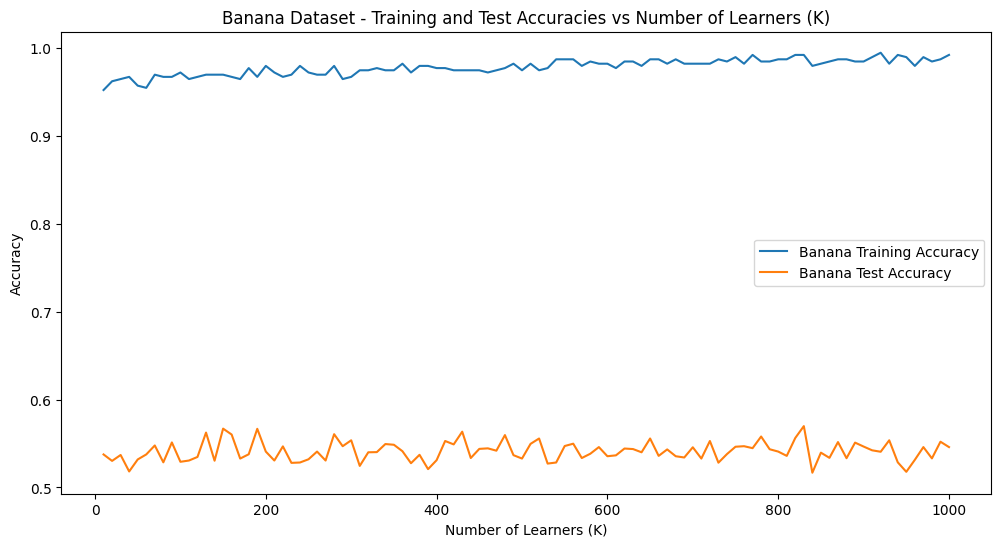

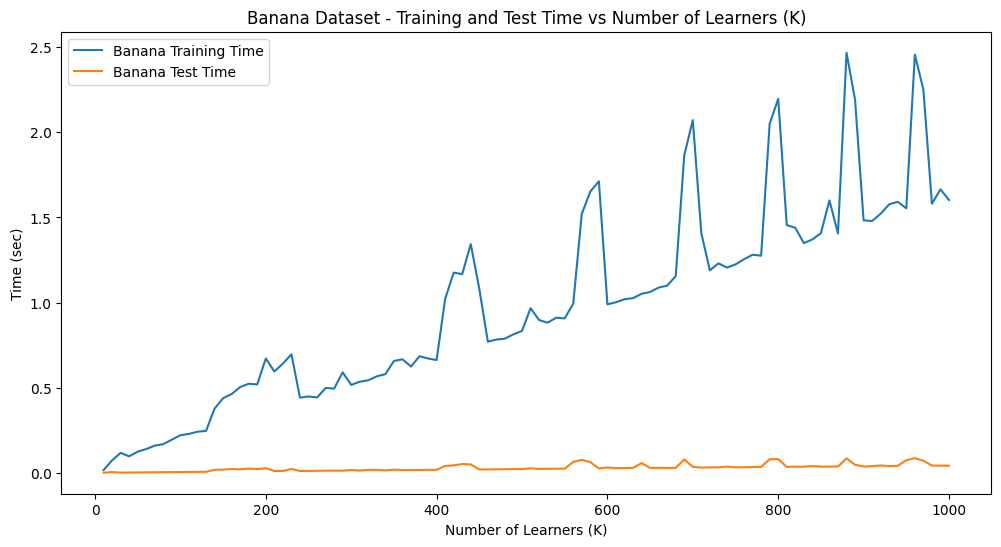

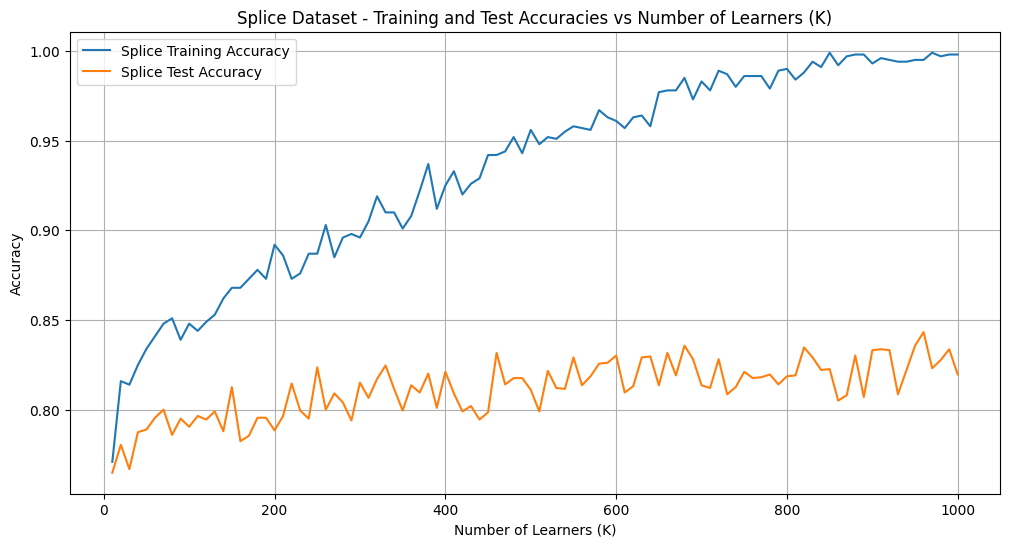

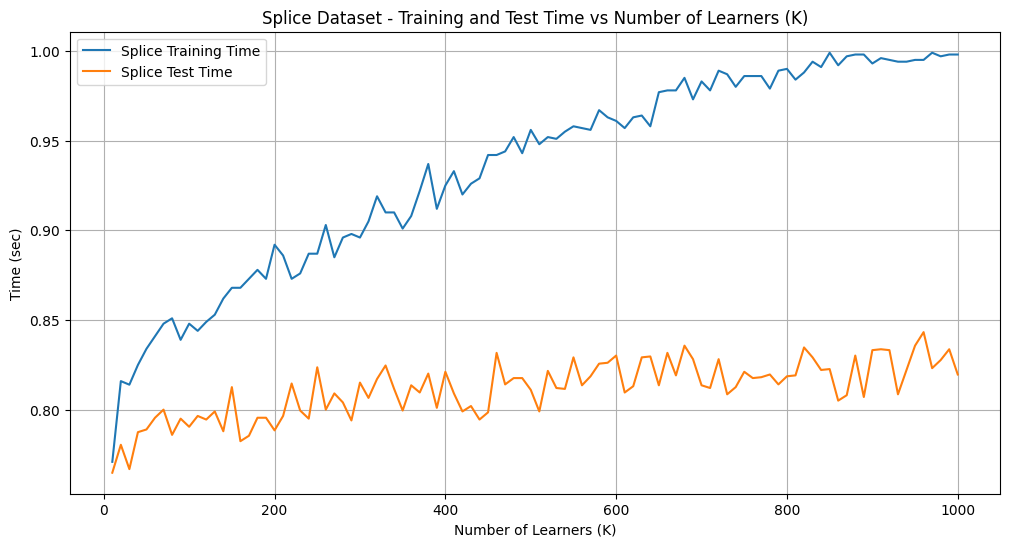

Banana Dataset - Final Training Accuracy: 99.25%
Banana Dataset - Final Test Accuracy: 54.59%
Splice Dataset - Final Training Accuracy: 99.80%
Splice Dataset - Final Test Accuracy: 81.97%
Banana Dataset - Final Training Time: 1.60 seconds
Banana Dataset - Final Test Time: 0.04 seconds
Splice Dataset - Final Training Time: 8.22 seconds
Splice Dataset - Final Test Time: 0.04 seconds


In [ ]:
main()

### 3. SVM Classifier

In [ ]:
%%capture
!pip install -U libsvm-official

In [ ]:
cd libsvm/python

In [ ]:
%%capture
!make

In [ ]:
cd ../..

In [ ]:
from libsvm.svmutil import *
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
import time

In [ ]:
# Function to read the LibSVM-formatted data
def load_libsvm_data(filename):
    y, x_dic = svm_read_problem(filename)
    num_samples = len(y)
    num_features = max(max(sample.keys()) for sample in x_dic)
    x = np.zeros((num_samples, num_features))
    for i, sample in enumerate(x_dic):
        for feature, value in sample.items():
            x[i, int(feature) - 1] = value  # This converts the feature index to an array index
    return x, y

In [ ]:
# Shuffle and split data into training and testing sets
def sample_data(x, y, num_train, num_test):
    merged = list(zip(x, y))
    np.random.shuffle(merged)
    x_shuffled, y_shuffled = zip(*merged)
    x_shuffled = np.array(x_shuffled)
    y_shuffled = np.array(y_shuffled)
    x_train, y_train = x_shuffled[:num_train], y_shuffled[:num_train]
    x_test, y_test = x_shuffled[num_train:num_train+num_test], y_shuffled[num_train:num_train+num_test]
    return x_train, y_train, x_test, y_test #Returns the features and labels as separate lists further split into training and testing sets

In [ ]:
# Perform a grid search for all the hyperparameters
def perform_grid_search(x_train, y_train, kernel_type):
    if kernel_type == 'linear':
        param_grid = {'C': [0.1, 1, 10, 100]}
        svm_model = SVC(kernel='linear')
    elif kernel_type == 'polynomial':
        param_grid = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': [0.001, 0.01, 0.1, 1]}
        svm_model = SVC(kernel='poly')
    elif kernel_type == 'gaussian':
        param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
        svm_model = SVC(kernel='rbf')
    elif kernel_type == 'sigmoid':
        param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
        svm_model = SVC(kernel='sigmoid')
    else:
        raise ValueError("KERNEL TYPE INVALID. This only accepts the following kernels: 'linear', 'polynomial', 'gaussian', and 'sigmoid'.")

    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_parameters = grid_search.best_params_
    return best_parameters

In [ ]:
# Training the SVM model
def train_svm(x_train, y_train, svm_parameters):
    time_start = time.time()
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)

    # Define kernel type
    kernel_type = svm_parameters['kernel']

    # Perform grid search for hyperparameters
    best_parameters = perform_grid_search(x_train_scaled, y_train, kernel_type)
    print(f"Best parameters for {kernel_type.capitalize()} Kernel:", best_parameters)

    # Create SVM with best hyperparameters
    if kernel_type == 'linear':
        best_C = best_parameters['C']
        model = SVC(kernel='linear', C=best_C)
    elif kernel_type == 'polynomial':
        best_C = best_parameters['C']
        best_degree = best_parameters['degree']
        best_gamma = best_parameters['gamma']
        model = SVC(kernel='poly', C=best_C, degree=best_degree, gamma=best_gamma)
    elif kernel_type == 'gaussian':
        best_C = best_parameters['C']
        best_gamma = best_parameters['gamma']
        model = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
    elif kernel_type == 'sigmoid':
        best_C = best_parameters['C']
        best_gamma = best_parameters['gamma']
        model = SVC(kernel='sigmoid', C=best_C, gamma=best_gamma)

    # Train the model
    model.fit(x_train_scaled, y_train)
    time_end = time.time()
    train_time = time_end - time_start
    return model, scaler, train_time

In [ ]:
# Testing the SVM model
def test_svm(model, x_test, scaler):
    time_start = time.time()
    x_test_scaled = scaler.transform(x_test)
    p_label = model.predict(x_test_scaled)
    time_end = time.time()
    test_time = time_end - time_start
    return p_label, test_time


In [ ]:
# Evaluate performance of SVM model
def evaluate_performance(y_true, y_pred):
    accuracy = sum(1 for true_label, pred_label in zip(y_true, y_pred) if true_label == pred_label) / len(y_true)
    return accuracy

In [ ]:
# Full SVM model
def main():
    # Define the datasets
    datasets = {
        "banana": "banana_data.libsvm",
        "splice": "splice_data.libsvm"
    }

    # Define the SVM parameters
    svm_parameters = {
        "linear": {"kernel": "linear"},
        "sigmoid": {"kernel": "sigmoid"},
        "polynomial": {"kernel": "polynomial"},
        "gaussian": {"kernel": "gaussian"}

    }

    # Iterate over datasets
    for dataset_name, dataset_file in datasets.items():
        x, y = load_libsvm_data(dataset_file)
        x_train, y_train, x_test, y_test = sample_data(x, y, 400, 4900) if dataset_name == "banana" else sample_data(x, y, 1000, 2175)

        print(f"\n{dataset_name.capitalize()} Dataset:")

        # Iterate over different SVM types
        for svm_type, parameters in svm_parameters.items():
            print(f"\n{svm_type.capitalize()} Kernel:")

            # Train SVM model
            model, scaler, train_time = train_svm(x_train, y_train, parameters)

            # Test SVM model
            p_label, test_time = test_svm(model, x_test, scaler)

            # Evaluate performance
            accuracy = evaluate_performance(y_test, p_label)

            # Print results
            print(f'Accuracy: {accuracy * 100:.2f} %')
            print(f'Train Time: {train_time:.2f} seconds')
            print(f'Test Time: {test_time:.2f} seconds')



In [ ]:
# Run the main function
if __name__ == "__main__":
    main() # Entry point of the script; execute main function and capture results


Banana Dataset:

Linear Kernel:
Best parameters for Linear Kernel: {'C': 0.1}
Accuracy: 55.31 %
Train Time: 1.68 seconds
Test Time: 0.08 seconds

Sigmoid Kernel:
Best parameters for Sigmoid Kernel: {'C': 0.1, 'gamma': 0.001}
Accuracy: 55.31 %
Train Time: 0.96 seconds
Test Time: 0.07 seconds

Polynomial Kernel:
Best parameters for Polynomial Kernel: {'C': 1, 'degree': 2, 'gamma': 1}
Accuracy: 67.12 %
Train Time: 5.89 seconds
Test Time: 0.07 seconds

Gaussian Kernel:
Best parameters for Gaussian Kernel: {'C': 1, 'gamma': 1}
Accuracy: 89.16 %
Train Time: 0.89 seconds
Test Time: 0.06 seconds

Splice Dataset:

Linear Kernel:
Best parameters for Linear Kernel: {'C': 0.1}
Accuracy: 83.02 %
Train Time: 75.61 seconds
Test Time: 0.04 seconds

Sigmoid Kernel:
Best parameters for Sigmoid Kernel: {'C': 10, 'gamma': 0.001}
Accuracy: 83.73 %
Train Time: 3.06 seconds
Test Time: 0.13 seconds

Polynomial Kernel:
Best parameters for Polynomial Kernel: {'C': 0.1, 'degree': 3, 'gamma': 0.1}
Accuracy: 83.1

### 4. Performance Comparison

Based on the results, we can make a comparison between the Support Vector Machine (SVM) and Boosted Perceptron classifiers for the banana and splice datasets. The comparison is based on the accuracy metrics, where accuracy is the percentage of test set samples that were correctly classified.

For the **banana dataset**:
- **SVM** achieves a testing accuracy of **89.16%**.
- **Boosted Perceptron** achieves a test accuracy of **54.59%** but has a higher training accuracy of **99.25%**.

For the **splice dataset**:
- **SVM** achieves a testing accuracy of **88.9%%**.
- **Boosted Perceptron** has a lower test accuracy of **81.97%** but, like with the banana dataset, shows a very high training accuracy of **99.80%**.

**Training Accuracy** refers to the classifier's performance on the same dataset that was used to train it. High training accuracy indicates that the classifier has effectively learned from the training data.

**Test Accuracy** is the more critical metric, as it measures the classifier's performance on unseen data, demonstrating its ability to generalize from what it has learned.

In this case, **SVM outperforms the Boosted Perceptron on the splice dataset** in terms of test accuracy, which is crucial for evaluating the model's performance on unseen data. For the banana dataset, the performance is similar between the two classifiers, with SVM having a slight edge.

It's worth noting that the Boosted Perceptron shows a tendency to overfit the training data, given the very high training accuracies compared to the test accuracies. Overfitting means that the model has learned the training data too well, including its noise and outliers, which can negatively impact the performance on the test set.